In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

In [8]:
from anemoi.datasets import open_dataset
from anemoi.graphs.nodes.builders.from_healpix import HEALPixNodes
from anemoi.datasets.grids import cutout_mask

In [3]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data"
    return open_dataset(
        cutout=[
            {
                "dataset": f"{data_dir}/hrrr.zarr",
                "trim_edge": trim_edge,
            },
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [12]:
hrrr = xr.open_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr_15km.nc")
hrrr = hrrr.isel(
    x=slice(10, -11),
    y=slice(10, -11),
    x_b=slice(10, -11),
    y_b=slice(10, -11),
)

In [22]:
data = open_nested(trim_edge=[10, 11, 10, 11], min_distance_km=15)
n_cutout = data.grids[0]
print(n_cutout)

Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr has missing dates


64220


In [83]:
gmesh = HEALPixNodes(resolution=5, name="global").get_coordinates()
gmesh = np.rad2deg(np.asarray(gmesh))
hmesh = HEALPixNodes(resolution=7, name="nest").get_coordinates()
hmesh = np.rad2deg(np.asarray(hmesh))

Create a mask on the hmesh, which right now is global.
Then use the inverse mask to select only the points we care about

In [84]:
first_mask = cutout_mask(
    lats=hrrr.lat.values.flatten(),
    lons=hrrr.lon.values.flatten(),
    global_lats=hmesh[:, 0],
    global_lons=hmesh[:, 1],
    min_distance_km=2*15,
)
    

Now make the mask we actually want

In [85]:
mask = cutout_mask(
    lats=hmesh[~first_mask, 0],
    lons=hmesh[~first_mask, 1],
    global_lats=gmesh[:, 0],
    global_lons=gmesh[:, 1],
    min_distance_km=2*15,
)

In [86]:
mask.sum()

11940

In [87]:
gcut = gmesh[mask]
hnest= hmesh[~first_mask]

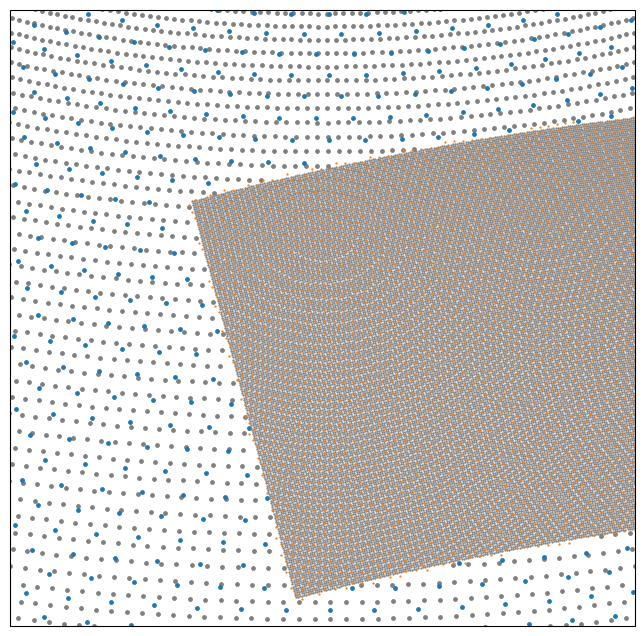

In [96]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(12,8),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x,y, x_d, y_d, s in zip(
    [gcut[:, 1], hnest[:, 1]],
    [gcut[:, 0], hnest[:, 0]],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [6, .4],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    ax.scatter(x_d, y_d, color="gray", **kw)
    ax.scatter(x,y, **kw)
ax.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())

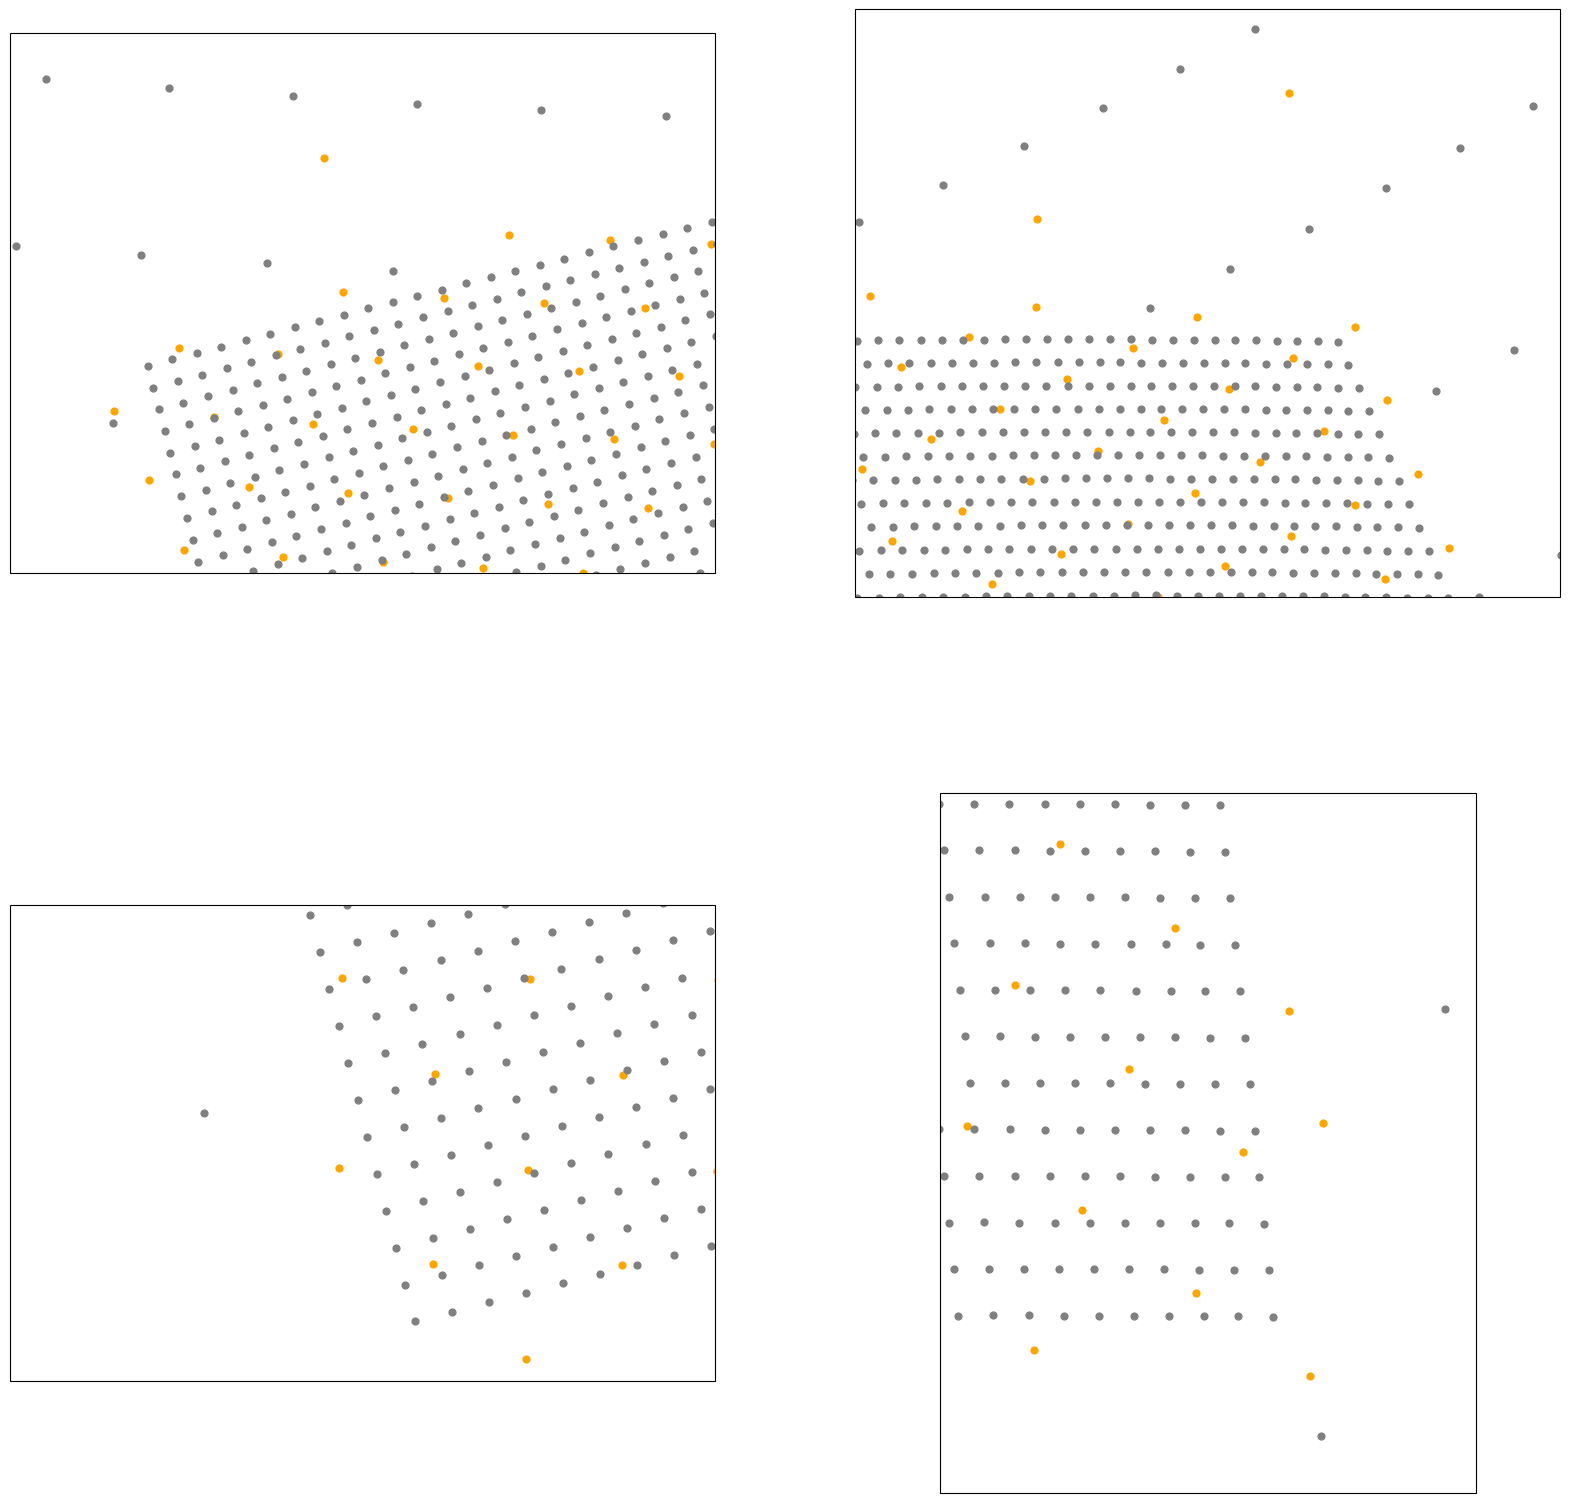

In [97]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(20,20),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x, y, x_d, y_d, s in zip(
    [gcut[:, 1], hnest[:, 1]],
    [gcut[:, 0], hnest[:, 0]],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [24, 2*12],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    for ax in axs.flatten():
        ax.scatter(x,y, color="orange", **kw)
        ax.scatter(x_d, y_d, color="gray", **kw)
# The overview
#axs[0].set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
#axs[1].set_extent([-125, -115, 20, 30], crs=ccrs.PlateCarree())

axs[0, 0].set_extent([227.85, 232.85, 45.8, 48.8], crs=ccrs.PlateCarree())
#axs[0, 0].set_extent([180, 250.85, 30.2, 48.6], crs=ccrs.PlateCarree())
axs[0, 1].set_extent([292.6, 297.6, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[1, 0].set_extent([236.8, 239.4, 22.6, 24.2], crs=ccrs.PlateCarree())
axs[1, 1].set_extent([285.6, 287.2, 22.55, 24.2], crs=ccrs.PlateCarree())
##fig.savefig(f"mesh_and_data_nodes.jpeg", bbox_inches="tight", dpi=300)

In [98]:
clon = np.concatenate([gcut[:, 1], hnest[:, 1]])
clat = np.concatenate([gcut[:, 0], hnest[:, 0]])
coords = np.stack([clat, clon], axis=-1)

In [99]:
len(coords)

17554

In [100]:
gcut.shape

(11940, 2)

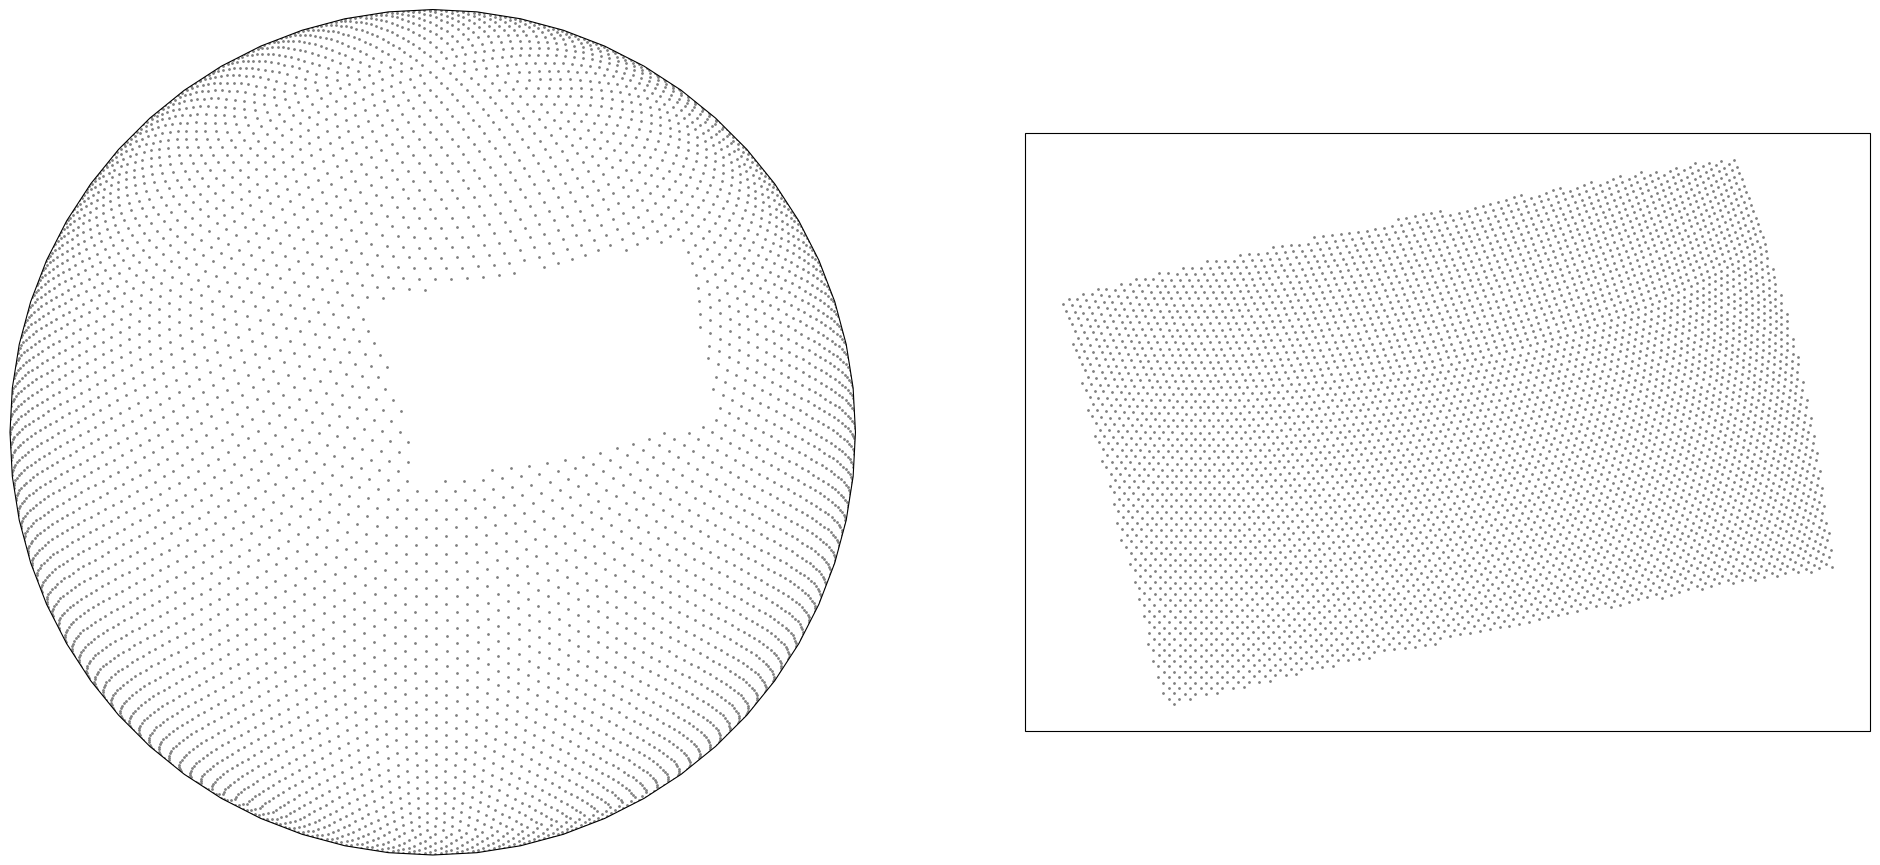

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(2*12, 2*10), subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=30)})

for cds, ax in zip([gmesh[mask], hmesh[~first_mask]], axs):
    ax.scatter(
        cds[:, 1],
        cds[:, 0],
        marker="o",
        color="gray",
        s=1,
        transform=ccrs.PlateCarree(),
    )

In [103]:
32307*2

64614